# Replica of Erk (2016)

** CONTENT **

* **Computation of Property Overlap**
* **Computation of Similarity** (Distributional Model)
* **Linear Regression Model** (i.e. f(overlap) ~ similarity))
* **Experiments**
    * Experiment 1: "All alligators are dangerous."
    * Experiment 2: "All alligators are edible."
    * Experiment 3: "All alligators are animals."

# Property Overlap 
**McRae et al. (2005) Property Norms**

In [51]:
import pandas as pd
import numpy as np
from collections import defaultdict

In [52]:
import os
os.chdir('/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/DISTRIBUTIONAL_SEMANTICS/DATA/McRae-BRM-InPress')

In [53]:
df = pd.read_csv('CONCS_FEATS_concstats_brm.xls', delimiter='\t')

In [54]:
df.head()

,Concept,Feature,WB_Label,WB_Maj,WB_Min,BR_Label,Prod_Freq,Rank_PF,Sum_PF_No_Tax,CPF,...,Num_Func,Num_Vis_Mot,Num_VisF&S,Num_Vis_Col,Num_Sound,Num_Taste,Num_Smell,Num_Tact,Num_Ency,Num_Tax
0,accordion,a_musical_instrument,superordinate,c,h,taxonomic,28,1,NaN,18,...,2,0,2,0,2,0,0,0,2,1
1,accordion,associated_with_polkas,associated_entity,s,e,encyclopaedic,9,4,9.0,1,...,2,0,2,0,2,0,0,0,2,1
2,accordion,has_buttons,external_component,e,ce,visual-form_and_surface,8,5,163.0,13,...,2,0,2,0,2,0,0,0,2,1
3,accordion,has_keys,external_component,e,ce,visual-form_and_surface,17,2,108.0,7,...,2,0,2,0,2,0,0,0,2,1
4,accordion,inbeh_-_produces_music,entity_behavior,e,b,sound,6,7,178.0,13,...,2,0,2,0,2,0,0,0,2,1


In [55]:
vocab = list(set(df['Concept']))
word2features = defaultdict(set)

In [56]:
df = df.set_index(df['Concept'])
df.head()

,Concept,Feature,WB_Label,WB_Maj,WB_Min,BR_Label,Prod_Freq,Rank_PF,Sum_PF_No_Tax,CPF,...,Num_Func,Num_Vis_Mot,Num_VisF&S,Num_Vis_Col,Num_Sound,Num_Taste,Num_Smell,Num_Tact,Num_Ency,Num_Tax
Concept,,,,,,,,,,,,,,,,,,,,,
accordion,accordion,a_musical_instrument,superordinate,c,h,taxonomic,28,1,NaN,18,...,2,0,2,0,2,0,0,0,2,1
accordion,accordion,associated_with_polkas,associated_entity,s,e,encyclopaedic,9,4,9.0,1,...,2,0,2,0,2,0,0,0,2,1
accordion,accordion,has_buttons,external_component,e,ce,visual-form_and_surface,8,5,163.0,13,...,2,0,2,0,2,0,0,0,2,1
accordion,accordion,has_keys,external_component,e,ce,visual-form_and_surface,17,2,108.0,7,...,2,0,2,0,2,0,0,0,2,1
accordion,accordion,inbeh_-_produces_music,entity_behavior,e,b,sound,6,7,178.0,13,...,2,0,2,0,2,0,0,0,2,1


In [62]:
for word in vocab:
    word2features[word] = set(df.ix[word]['Feature'])
# set(df.ix['fawn']['Feature']) retrieves a set of features under 'fawn'
#  NB: _set_ instead of _list_ for the convenience of computing Jaccard
#  ['a_baby_deer',
#  'a_deer',
#  'a_mammal',
#  'an_animal',
#  'beh_-_eats',
#  'beh_-_eats_grass',
#  'beh_-_eats_leaves',
#  'eg_-_bambi',
#  ... ]

In [63]:
def property_overlap(w1,w2,theta=3):
    assert w1 in vocab and w2 in vocab
    w1_features, w2_features = word2features[w1], word2features[w2]
#     if len(w1_features)<theta or len(w2_features)<theta: 
#         print "Reliable Property Threshold: %d (%s: %d; %s: %d)" % (theta,
#                                                                     w1,len(w1_features),
#                                                                     w2,len(w2_features))
#         return
    return len(w1_features.intersection(w2_features)) / \
            float(len(w1_features.union(w2_features)))

In [64]:
property_overlap('alligator','crocodile')

0.5714285714285714

# Distributional Model

In [10]:
import os
os.chdir("/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/DISTRIBUTIONAL_SEMANTICS/ASSIGNMENT_03")

In [11]:
import nltk
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
from collections import defaultdict
from functools import partial
from itertools import permutations, product
punctuation = '!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~'

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
def load_wiki(cutoffFreq=50):
    
    print "... extracting data"
    with open('wikicorpus.txt','rb') as f:
        raw = f.readlines()
    raw = [sent[4:].split() for sent in raw if sent.startswith('<c>')] 
        # sent[4:]: get rid of initial <c>.
        # extract sentences; split sentences into word complexes.
    raw = [[map(partial(str.split, word), '|') for word in sent] for sent in raw] 
        # split word complexes into words.
    
    print "... cleaning data"
    sents = [[word[0][1].lower() for word in sent if len(word[0])>1 
              and (word[0][2].startswith('N') or word[0][2]=='.')
              and word[0][1].lower() not in stopwords
              and word[0][1] not in punctuation] for sent in raw]
        # extract lemmas => complete sents corpus .
    
    print "... building token list and vocabulary"
    tokens = [word for sent in sents for word in sent]
        # type: list of words.
    fdist = nltk.FreqDist(tokens)
    vocab = list(set(tokens))   
    
    print "... saving words that appear at least %d times in vocabulary" % cutoffFreq
    vocab = [word for word in vocab if fdist[word] >= cutoffFreq]
        # vocab is not returned, because the k-frequent cut latter can change it.
    sents = [[word.decode('utf-8','ignore') for word in sent if word in vocab] for sent in sents]
        # type: list of all words in the corpus, separated by periods.
        
    return [tokens, vocab, sents]

In [14]:
%%time
tokens, vocab, sents = load_wiki(20)

... extracting data
... cleaning data
... building token list and vocabulary
... saving top 20-frequent in vocabulary
CPU times: user 8min 15s, sys: 7.54 s, total: 8min 23s
Wall time: 8min 21s


In [15]:
import numpy as np

In [16]:
# SIMILARITY MEASURES
def cosine(w2w):
    w2w_norm = w2w / np.apply_along_axis(lambda r: np.sqrt(np.dot(r,r))
                               , 1, w2w)[:,np.newaxis]
    return np.dot(w2w_norm, w2w_norm.T)
    
def ppmi(w2w):
    rowSums, colSums, totalSums = w2w.sum(axis=1), w2w.sum(axis=0), w2w.sum()
    pwi, pwj, ppmiMatrix = rowSums/totalSums, colSums/totalSums, w2w/totalSums
    ppmiMatrix /= pwi[:,np.newaxis] # * 1/pwi by row.
    ppmiMatrix /= pwj # * 1/pwj by col.
    ppmiMatrix = np.nan_to_num(np.log(ppmiMatrix)) # compute pmi.
    ppmiMatrix = np.maximum(ppmiMatrix, 0) # compute ppmi.
    return ppmiMatrix

In [17]:
class DistributionalModel:
    
    def __init__(self, data=sents, kFrequent=50):
        self.sents = sents # a list of lists of words.
        self.vocab = list({word for sent in sents for word in sent})
        self.word2idx = {word:i for i,word in enumerate(self.vocab)}
        self.idx = {i:word for word,i in self.word2idx.iteritems()}
    
    def build_w2w_matrix(self, win_size):
        
        print "... counting words"
        cooccurrence_dict = defaultdict(int)
        for sent in self.sents:
            for i,word in enumerate(sent):
                contexts = sent[max(0,i-win_size):i] + \
                           sent[min(i+1,len(sent)):min(i+1+win_size,len(sent))]
                for context in contexts:
                    cooccurrence_dict[(self.word2idx[word],self.word2idx[context])] += 1
        
        print "... building cooccurrence matrix"
        self.w2w = np.zeros((len(self.vocab),len(self.vocab)))
        for (widx_i,widx_j),count in cooccurrence_dict.iteritems():
            self.w2w[widx_i][widx_j] = count   
    
    def build_similarity_matrix(self, similarity=ppmi):
        self.sim_matrix = similarity(self.w2w)
        return self.sim_matrix
    
    def get_similarity(self, w1, w2):
        assert w1 in self.vocab and w2 in self.vocab
        return self.sim_matrix[self.word2idx[w1]][self.word2idx[w2]]
    
    def k_most_similar(self, words, k=20):
        assert len(words)==len(filter(lambda w:1 if w in self.vocab else 0, words))
        w2sim = {}
        for word in words:
            sim_list = self.sim_matrix[self.word2idx[word]]
            w2sim[word] = map(lambda idx:(self.idx2word[idx],
                                          self.sim_matrix[self.word2idx[word]][idx]),
                              np.argsort(sim_list)[::-1][1:k+1])
            # [1:k+1]: skip self-similarty.
        return w2sim

In [18]:
%%time
dm = DistributionalModel(sents)

CPU times: user 446 ms, sys: 14.6 ms, total: 460 ms
Wall time: 452 ms


In [19]:
%%time
dm.build_w2w_matrix(win_size=2)

... counting words
... building cooccurrence matrix
CPU times: user 13 s, sys: 716 ms, total: 13.7 s
Wall time: 13.6 s


In [20]:
%%time
ppmi_similarities = dm.build_similarity_matrix(ppmi)

CPU times: user 5.23 s, sys: 2.29 s, total: 7.52 s
Wall time: 7.85 s


In [21]:
%%time
cosine_similarities = dm.build_similarity_matrix(cosine)

CPU times: user 2min 40s, sys: 1.25 s, total: 2min 42s
Wall time: 24.9 s


In [22]:
print dm.get_similarity('alligator','crocodile')
print dm.get_similarity('alligator','trout')

0.510481965141
0.390749299795


# Linear Regression 
**x = overlap, y = distributional similarity**

In [23]:
from sklearn.linear_model import LinearRegression
# from scipy import stats # TOO DARN SLOW, KERNEL DEAD.

In [24]:
import os
os.chdir('/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/DISTRIBUTIONAL_SEMANTICS/DATA')
names = ['mpg','cylinders','displacement','horsepower','weight','acceleration',
         'model_year','origin','car_name']
df = pd.read_csv('carmpg.txt', delimiter=r'\s+', names=names)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [487]:
# X, Y = np.array(df['horsepower']), np.array(df['mpg'])

In [25]:
X, Y = np.asarray(df['horsepower'])[:,np.newaxis], np.asarray(df['mpg'])[:,np.newaxis]
lr = LinearRegression()
lr.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
# gradient, intercept, r_value, p_value, std_err = stats.linregress(X,Y)

In [27]:
# r_value**2

# Property-Overlap & Cosine-Similarity Matrices
**McRae et al. (2005) Property Norms**

**NB: 323 outof 541 words in PN are in distributional similarity matrix**

In [66]:
import random

In [67]:
print dm.get_similarity('alligator','crocodile')
print dm.get_similarity('alligator','trout')

0.510481965141
0.390749299795


In [68]:
print property_overlap('alligator','crocodile')
print property_overlap('alligator','trout')

0.571428571429
0.2


In [69]:
target_vocab = filter(lambda w: w in dm.vocab, vocab) # this vocab is from the first section McRae.

In [70]:
from itertools import combinations
w2i = {w:i for i,w in enumerate(target_vocab)}
i2w = {i:w for i,w in enumerate(target_vocab)}

In [71]:
%%time
ovl_matrix = np.zeros((len(target_vocab),len(target_vocab)))
sim_matrix = np.zeros((len(target_vocab),len(target_vocab)))
ovls, sims = [], []
for w_i,w_j in combinations(target_vocab, 2):
    ovl_ij, sim_ij = property_overlap(w_i,w_j), dm.get_similarity(w_i,w_j)
    ovl_matrix[w2i[w_i]][w2i[w_j]] = ovl_matrix[w2i[w_j]][w2i[w_i]] = ovl_ij
    sim_matrix[w2i[w_i]][w2i[w_j]] = sim_matrix[w2i[w_j]][w2i[w_i]] = sim_ij
    ovls.append(ovl_ij)
    sims.append(sim_ij)

CPU times: user 1min 10s, sys: 452 ms, total: 1min 11s
Wall time: 1min 10s


In [72]:
def get_ovl_sim(w1,w2):
    return [ovl_matrix[w2i[w1]][w2i[w2]], sim_matrix[w2i[w1]][w2i[w2]]]
print get_ovl_sim('alligator','crocodile')

[0.5714285714285714, 0.51048196514146693]


In [73]:
ovls = np.asarray(ovls)[:,np.newaxis]
sims = np.asarray(sims)[:,np.newaxis]
    # for using sklearn.linear_models.LinearRegression

In [74]:
ovls.shape

(52003, 1)

In [75]:
lr = LinearRegression()
lr.fit(ovls,sims)
print lr.coef_, lr.intercept_

[[ 0.15304673]] [ 0.47091774]


In [ ]:
# gradient, intercept, r_value, p_value, std_err = stats.linregress(ovls,sims)
# def predict(o):
#     return intercept + gradient*o

In [76]:
def sample_ovl_sim(K=10):
    x, y = [], []
    for k in xrange(K):
        w_i,w_j = random.sample(target_vocab,2)
        ovl_sim = get_ovl_sim(w_i,w_j)
        x.append(ovl_sim[0])
        y.append(ovl_sim[1])
    return [np.asarray(x)[:,np.newaxis],
            np.asarray(y)[:,np.newaxis]]

In [81]:
x, y = sample_ovl_sim(100)
import matplotlib.pyplot as plt
%matplotlib inline

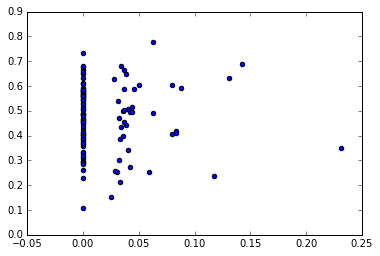

In [82]:
plt.scatter(x,y)

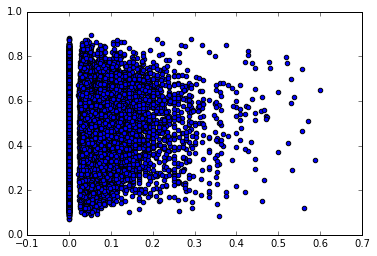

In [83]:
plt.scatter(ovls,sims)

In [84]:
print np.mean(ovls), np.std(ovls)
print np.mean(sims), np.std(sims)

0.0204232870744 0.0421677618595
0.474043456525 0.14693930606


In [87]:
from scipy.stats import norm
sse = sum((sim-lr.predict(ovl))**2 for ovl,sim in zip(ovls,sims))
rste = np.sqrt(sse/(len(ovls)-2)) # 0.14680034

In [135]:
def p_s_given_o(o,s): # P(E_dist | w)
    f_o = lr.predict(o)
    return 1-norm(f_o,rste).cdf(s)[0][0] # raw computation returns array([[..]]).

In [136]:
p_s_given_o(.57,.51)

0.62855412136493527

In [93]:
ss_tot = sum((sim-np.mean(sims))**2 for sim in sims)
ss_tot

array([ 1122.80507608])

In [94]:
ss_reg = sum((lr.predict(ovl)-np.mean(sims))**2 for ovl in ovls)
ss_reg

array([[ 2.16589605]])

In [95]:
ss_res = sum((sim-lr.predict(ovl))**2 for ovl,sim in zip(ovls,sims))
ss_res

array([[ 1120.63918003]])

In [96]:
r_squared = 1 - ss_res/ss_tot
r_squared

array([[ 0.001929]])

# Experiment: Inference

In [303]:
def coin():
    return 1 if random.uniform(0,1)>.5 else 0

### A. Experiment 1

** We know a lot about crocodiles, that they are *animals*, *dangerous*, *scaly*, etc., and we only know that alligators are *alligator*. We would like to know how the distributional similarity of *crocodile* and *alligator* will affect the degree of property uncertainty that we have about alligators. **

** SENTENCE: "All alligators are dangerous" **

In [146]:
import random
from scipy.stats import norm

##### SAMPLING $P_0(w)$

In [309]:
class W1:
    
    def __init__(self):
        self.U = ['e1','e2','e3','e4','e5','e6','e7','e8','e9','e10']
        self.pred2domain = defaultdict(list)
        for pred in ['alligator','crocodile']:
            for entity in self.U:
                if coin()==1:
                    self.pred2domain[pred].append(entity)
        for pred in ['animal','dangerous','scaly']:
            for entity in self.U:
                if entity in self.pred2domain['crocodile']:
                    self.pred2domain[pred].append(entity)
                else:
                    if coin()==1:
                        self.pred2domain[pred].append(entity) 
    
    def get_world(self):
        return self.pred2domain
    
    def all_alligators_are_dangerous(self):
        for entity in self.U:
            if entity not in self.pred2domain['alligator'] or \
               entity in self.pred2domain['alligator'] and entity in self.pred2domain['dangerous']:
                    pass
            else: return 0
        return 1
    

In [310]:
def p0_sentence1(sample_size=2000):
    # P_0(sentence) ~= .26
    true = 0.
    for i in xrange(sample_size):
        true += W1().all_alligators_are_dangerous()
    return true / sample_size

In [311]:
p0_sentence1()

0.273

##### SAMPLING $P_1(w)$

In [312]:
print get_ovl_sim('alligator','crocodile')

[0.5714285714285714, 0.51048196514146693]


In [313]:
# THE VALUE FROM CURRENT STUDY (wiki dump)
beta1, beta0 = 0.15304673, 0.47091774 # f_o = beta0 + beta1*o, from previous.
ste = 0.14680034 # N(f_o,ste), from previous.
o = 0.5714285714285714 # ovl('alligator','crocodile')
s = 0.51048196514146693 # sim('alligator','crocodile')

# THE VALUES FROM Erk(2016)
# beta1, beta0 = 1.8, .35
# ste = .15
# o = .57
# s = .93

In [314]:
f_o = beta0 + beta1*o
g_0 = norm(f_o,ste**2) # g_0 ~ N(f_o,ste^2)

In [315]:
def p1_sentence1(sample_size=2000):
    # P_1(sentence)
    ws = []
    for i in xrange(sample_size):
        w = W1()
        s_prime = g_0.rvs()
        if s_prime >= s:
            ws.append(w)
    true = 0.
    for w in ws:
        true += w.all_alligators_are_dangerous()
    print "Pr(acceptance) = %.2f%%" % (len(ws)/float(sample_size)*100)
    return true / len(ws)

In [316]:
p1_sentence1()

Pr(acceptance) = 98.80%


0.2565789473684211

### B. Experiment 2

** We know a lot about trouts, that they are *animals*, *aquatic*, *edible*, etc., and we only know that alligators are *alligator*. We would like to know how the distributional similarity of *trout* and *alligator* will affect the degree of property uncertainty that we have about alligators. **

** SENTENCE: "All alligators are edible" **

##### SAMPLE $P_0(w)$

In [349]:
class W2:
    
    def __init__(self):
        self.U = ['e1','e2','e3','e4','e5','e6','e7','e8','e9','e10']
        self.pred2domain = defaultdict(list)
        for pred in ['alligator','trout']:
            for entity in self.U:
                if coin()==1:
                    self.pred2domain[pred].append(entity)
        for pred in ['animal','aquatic','edible']:
            for entity in self.U:
                if entity in self.pred2domain['trout']:
                    self.pred2domain[pred].append(entity)
                else:
                    if coin()==1:
                        self.pred2domain[pred].append(entity) 
    
    def get_world(self):
        return self.pred2domain
    
    def all_alligators_are_edible(self):
        for entity in self.U:
            if entity not in self.pred2domain['alligator'] or \
               entity in self.pred2domain['alligator'] and entity in self.pred2domain['edible']:
                    pass
            else: return 0
        return 1
    

In [350]:
def p0_sentence2(sample_size=2000):
    true = 0.
    for i in xrange(sample_size):
        true += W2().all_alligators_are_edible()
    return true / sample_size

In [351]:
p0_sentence2()

0.262

##### SAMPLE $P_1(w)$

In [356]:
print get_ovl_sim('alligator','trout')

[0.20000000000000001, 0.39074929979530337]


In [357]:
# THE VALUE FROM CURRENT STUDY (wiki dump)
beta1, beta0 = 0.15304673, 0.47091774 # f_o = beta0 + beta1*o, from previous.
ste = 0.14680034 # N(f_o,ste), from previous.
o = 0.20000000000000001 # ovl('alligator','trout')
s = 0.39074929979530337 # sim('alligator','trout')

# THE VALUES FROM Erk(2016)
# beta1, beta0 = 1.8, .35
# ste = .15
# o = .2
# s = .68

In [358]:
f_o = beta0 + beta1*o
g_0 = norm(f_o,ste**2) # g_0 ~ N(f_o,ste^2)

In [359]:
def p1_sentence2(sample_size=2000):
    # P_1(sentence)
    ws = []
    for i in xrange(sample_size):
        w = W2()
        s_prime = g_0.rvs()
        if s_prime >= s:
            ws.append(w)
    true = 0.
    for w in ws:
        true += w.all_alligators_are_edible()
    print "Pr(acceptance) = %.2f%%" % (len(ws)/float(sample_size)*100)
    return true / len(ws)

In [360]:
p1_sentence2()

Pr(acceptance) = 100.00%


0.27

### C. Experiment 3

** SENTENCE: "All alligators are animals" **

##### SAMPLE $P_0(w)$

In [361]:
class W3:
    
    def __init__(self):
        self.U = ['e1','e2','e3','e4','e5','e6','e7','e8','e9','e10']
        self.pred2domain = defaultdict(list)
        for pred in ['alligator','crocodile','trout']:
            for entity in self.U:
                if coin()==1:
                    self.pred2domain[pred].append(entity)
        for pred in ['animal','aquatic','dangerous','edible','scaly']:
            for entity in self.U:
                if entity in self.pred2domain['crocodile'] and \
                   pred in ['animal','dangerous','scaly']:
                        self.pred2domain[pred].append(entity)
                elif entity in self.pred2domain['trout'] and \
                     pred in ['animal','dangerous','edible']:
                        self.pred2domain[pred].append(entity)
                else:
                    if coin()==1:
                        self.pred2domain[pred].append(entity) 
    
    def get_world(self):
        return self.pred2domain
    
    def all_alligators_are_animals(self):
        for entity in self.U:
            if entity not in self.pred2domain['alligator'] or \
               entity in self.pred2domain['alligator'] and entity in self.pred2domain['animal']:
                    pass
            else: return 0
        return 1

In [362]:
def p0_sentence3(sample_size=2000):
    true = 0.
    for i in xrange(sample_size):
        true += W3().all_alligators_are_animals()
    return true / sample_size

In [365]:
p0_sentence3()

0.55

##### SAMPLE $P_1(w)$

In [372]:
def p1_sentence3(g_0, s, sample_size=2000):
    # P_1(sentence)
    ws = []
    for i in xrange(sample_size):
        w = W3()
        s_prime = g_0.rvs()
        if s_prime >= s:
            ws.append(w)
    true = 0.
    for w in ws:
        true += w.all_alligators_are_animals()
    print "Pr(acceptance) = %.2f%%" % (len(ws)/float(sample_size)*100)
    return true / len(ws)

**Condition 1: only sim(alligator,crocodile) known**

In [374]:
print get_ovl_sim('alligator','crocodile')

[0.5714285714285714, 0.51048196514146693]


In [375]:
# THE VALUE FROM CURRENT STUDY (wiki dump)
beta1, beta0 = 0.15304673, 0.47091774 # f_o = beta0 + beta1*o, from previous.
ste = 0.14680034 # N(f_o,ste), from previous.
o = 0.5714285714285714 # ovl('alligator','crocodile')
s = 0.51048196514146693 # sim('alligator','crocodile')

# THE VALUES FROM Erk(2016)
# beta1, beta0 = 1.8, .35
# ste = .15
# o = .57
# s = .93

In [376]:
f_o = beta0 + beta1*o
g_0 = norm(f_o,ste**2) # g_0 ~ N(f_o,ste^2)

In [377]:
p1_sentence3(g_0=g_0, s=s, sample_size=2000)

Pr(acceptance) = 98.05%


0.5283018867924528

**Condition 2: only sim(alligator,trout) known**

In [378]:
print get_ovl_sim('alligator','trout')

[0.20000000000000001, 0.39074929979530337]


In [379]:
# THE VALUE FROM CURRENT STUDY (wiki dump)
beta1, beta0 = 0.15304673, 0.47091774 # f_o = beta0 + beta1*o, from previous.
ste = 0.14680034 # N(f_o,ste), from previous.
o = 0.20000000000000001 # ovl('alligator','trout')
s = 0.39074929979530337 # sim('alligator','trout')

# THE VALUES FROM Erk(2016)
# beta1, beta0 = 1.8, .35
# ste = .15
# o = .2
# s = .68

In [380]:
f_o = beta0 + beta1*o
g_0 = norm(f_o,ste**2) # g_0 ~ N(f_o,ste^2)

In [381]:
p1_sentence3(g_0=g_0, s=s, sample_size=2000)

Pr(acceptance) = 100.00%


0.545

**Condition 3: both sim(alligator,crocodile) and sim(alligator,trout) known**

In [370]:
print get_ovl_sim('alligator','crocodile')
print get_ovl_sim('alligator','trout')

[0.5714285714285714, 0.51048196514146693]
[0.20000000000000001, 0.39074929979530337]


In [385]:
# THE VALUE FROM CURRENT STUDY (wiki dump)
ste = 0.14680034 # N(f_o,ste), from previous.
beta1, beta0 = 0.15304673, 0.47091774 # f_o = beta0 + beta1*o, from previous.
o1 = 0.5714285714285714 # ovl('alligator','crocodile')
o2 = 0.20000000000000001 # ovl('alligator','trout')
s1 = 0.51048196514146693 # sim('alligator','crocodile')
s2 = 0.39074929979530337 # sim('alligator','trout')

# THE VALUES FROM Erk(2016)
# beta1, beta0 = 1.8, .35
# o1 = .57
# o2 = .2
# s1 = .93
# s2 = .68

In [386]:
def p1_sentence3(g_01, g_02, s1, s2, sample_size=2000):
    # P_1(sentence)
    ws = []
    for i in xrange(sample_size):
        w = W3()
        s1_prime = g_01.rvs()
        s2_prime = g_02.rvs()
        if s1_prime >= s1 or s2_prime >= s2:
            ws.append(w)
    true = 0.
    for w in ws:
        true += w.all_alligators_are_animals()
    print "Pr(acceptance) = %.2f%%" % (len(ws)/float(sample_size)*100)
    return true / len(ws)

In [387]:
f_o1 = beta0 + beta1*o1
g_01 = norm(f_o1,ste**2) 
f_o2 = beta0 + beta1*o2
g_02 = norm(f_o2,ste**2) 

In [389]:
p1_sentence3(g_01,g_02,s1,s2)

Pr(acceptance) = 100.00%


0.5225